# YAMnet Transfer learning Tutorial
- 얌넷의 전이학습(?)은 조금 다른 느낌
- TF - YAMnet의 출력은 scores, embeddings, spectrogram
- embeddings를 학습한 다른 모델을 만드는 과정 => Transfer Learning
- 알던 것과는 조금 다르다 ... !!!
  

## YAMnet Classification

In [1]:
### Dependendies
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_io as tfio
# tensorflow_io => ERROR
import librosa

# 항상 느끼는데, Tensorflow의 의존성 문제는 언제 터질지 모르는 폭탄 같음.

testing_wav_data: [ 0.02595747  0.0523409   0.06424945 ... -0.06736188 -0.06521396
 -0.06627087]
testing_wav_data.shape: (499322,)
type(testing_wav_data): <class 'numpy.ndarray'>


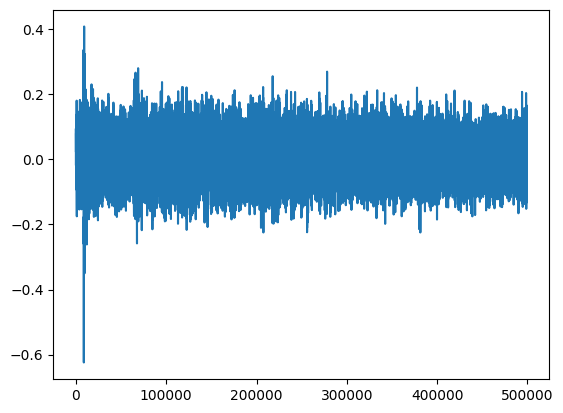

In [2]:
# test file to 16k_mono_channel
# WAV파일 => Float Tensor => 16kHz 모노 채널 오디오로 squeeze(resample)
def load_wav_16k_mono_librosa(filename):
    # librosa를 사용하여 파일 로드
    # sr=None이면 파일의 원래 샘플레이트를 유지, sr=16000이면 로드하면서 16kHz로 리샘플링
    audio, sample_rate = librosa.load(filename, sr=16000, mono=True)
    return audio
# test.wav를 16mono로 !
testing_wav_data = load_wav_16k_mono_librosa('test.wav')
print(f'testing_wav_data: {testing_wav_data}')
print(f'testing_wav_data.shape: {testing_wav_data.shape}')
print(f'type(testing_wav_data): {type(testing_wav_data)}')

# PLAY !
_ = plt.plot(testing_wav_data)
display.Audio(testing_wav_data, rate=16000)

-----------------------------
scores.shape: (64, 521)
embeddings.shape: (64, 1024)
spectrogram.shape: (3120, 64)
-----------------------------
Top 5 inferred classes and their scores:
1: Vehicle with score 0.3915
2: Emergency vehicle with score 0.2844
3: Motor vehicle (road) with score 0.2243
4: Siren with score 0.2154
5: Alarm with score 0.1896


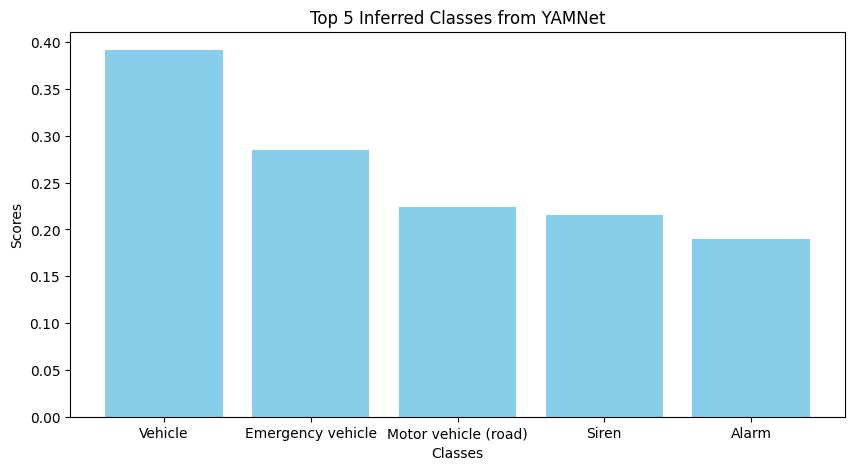

The embeddings shape: (64, 1024)


In [5]:
# Model Load
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# 클래스 매핑
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

# infer !
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
### 여기서 embeddings가 중요 !
### embedding을 학습한 다른 모델을 만드는 과정이 얌넷 전이학습의 기본 베이스
### yamnet은 특징 추출기로서의 기능만 !
print('-----------------------------')
print(f'scores.shape: {scores.shape}')
print(f'embeddings.shape: {embeddings.shape}')
print(f'spectrogram.shape: {spectrogram.shape}')
print('-----------------------------')

# 각 클래스에 대한 평균 점수 계산
class_scores = tf.reduce_mean(scores, axis=0)

# 상위 5개 클래스의 인덱스를 추출
top_classes = tf.argsort(class_scores, direction='DESCENDING')[:5]
top_scores = tf.gather(class_scores, top_classes)  # 상위 5개 클래스의 점수 추출

# 상위 5개 클래스의 이름을 추출
inferred_classes = [class_names[idx] for idx in top_classes]

# 결과 출력
print("Top 5 inferred classes and their scores:")
for i, (class_name, score) in enumerate(zip(inferred_classes, top_scores), 1):
    print(f"{i}: {class_name} with score {score:.4f}")

# 막대그래프로 결과 시각화
plt.figure(figsize=(10, 5))
plt.bar(inferred_classes, top_scores.numpy(), color='skyblue')  # 상위 5개 클래스 및 점수 그래프로 표현
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Top 5 Inferred Classes from YAMNet')
plt.show()

# 임베딩의 형태 출력
print(f"The embeddings shape: {embeddings.shape}")

## Transfer Learning !
- YAMnet을 특징 추출기로 이용 => 오디오의 embedding을 산출
- 산출한 embedding을 학습하는 다른 모델을 만든다 !